In [49]:
from __future__ import print_function, division

import numpy as np
from torchvision import datasets, transforms, models
import torchvision
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import LoopTimer 
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from torch.utils.data.sampler import SubsetRandomSampler
from random import shuffle

import skorch

In [2]:
# model = make_model('resnet50', num_classes=7, pretrained=True, input_size=(256, 256))

In [9]:
def check_files():
    data_loc = r"/home/disk/eos4/jkcm/Data/MEASURES/classified_data/npz/train"
    for folder in os.listdir(data_loc):
        for file in os.listdir(os.path.join(data_loc, folder)):
            l = np.load(os.path.join(data_loc, folder, file))
            print(l.files)
            
# check_files()
def npz_loader(path):
    l = np.load(path)
    r = l['Ref_Band2']*256
    g = l['Ref_Band4']*256
    b = l['Ref_Band7']*256
    rgb = np.stack([r,g,b], axis=2).astype('uint8')
#     sample = torch.from_numpy(rgb)
    sample = Image.fromarray(rgb)
    return sample

def valid_file(path):
    return os.path.basename(path)[:3] == "IMG" and path[-4:] == '.npz'

In [23]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
#         transforms.ToPILImage(mode='RGB'),
#         transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
#         transforms.ToPILImage(mode='RGB'),
        transforms.Resize(224),
#         transforms.Resize(255),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# npz_datasets = {x: datasets.DatasetFolder(r"/home/disk/eos4/jkcm/Data/MEASURES/classified_data/npz/{}".format(x), 
#                                             transform=data_transforms[x], 
#                                             target_transform=None, 
#                                             loader=npz_loader,
#                                             is_valid_file=valid_file)
#                   for x in ['train', 'val']}
old_npz_datasets = {x: datasets.ImageFolder(r"/home/disk/eos4/jkcm/Data/MEASURES/classified_data/npz/{}".format(x), 
                                            transform=data_transforms[x], 
                                            target_transform=None, 
                                            loader=npz_loader,
                                            is_valid_file=valid_file)
                  for x in ['train', 'val']}
old_dataloaders = {x: torch.utils.data.DataLoader(old_npz_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}

full_dataset = datasets.ImageFolder(r"/home/disk/eos4/jkcm/Data/MEASURES/classified_data/unified_filtered/good_npz/",
                                    transform=data_transforms['train'],
                                    target_transform=None,
                                    loader=npz_loader,
                                    is_valid_file=valid_file)


dataset_sizes = {x: len(old_npz_datasets[x]) for x in ['train', 'val']}
class_names = old_npz_datasets['train'].classes
device = 'cpu'


In [37]:
##make splits
labels = [i[1] for i in full_dataset]

In [71]:
k = 5
classes = list(set(labels))
indices_dict = {i: [] for i in set(classes)}
#split indices by category
for i, l in enumerate(labels):
    indices_dict[l].append(i)
#define the splits
split_dict = {i: [] for i in set(classes)}
for cat,indices in indices_dict.items():
    shuffle(indices)
    in_splits = [indices[i::k] for i in range(k)]
    split_dict[cat] = in_splits
#convenience define the splits, lists are cheap
splits = []
for i in range(k):
    train_indices = np.concatenate([np.concatenate([x for j,x in enumerate(splits) if j!=i]) for splits in split_dict.values()])
    val_indices = np.concatenate([splits[i] for splits in split_dict.values()])
    splits.append({"train": train_indices, "val": val_indices})

In [96]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, verbose=True):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            lt = LoopTimer.LoopTimer(dataset_sizes[phase]/dataloaders[phase].num_workers)
            for inputs, labels in dataloaders[phase]:
                if verbose:
                    lt.update()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

In [97]:

def make_model():
    model_ft = models.densenet121(pretrained=True)
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, len(class_names))
    # num_ftrs = model_ft.fc.in_features
    # model_ft.fc = nn.Linear(num_ftrs, len(class_names))
    model_ft = model_ft.to(device)
    return model_ft

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [99]:
### CV-version
models = []
for i,split in enumerate(splits):
    dataloaders = {x: torch.utils.data.DataLoader(full_dataset, batch_size=8, num_workers=8, 
                                             sampler=SubsetRandomSampler(split[x]))
              for x in ['train', 'val']}
    model = make_model()
    model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5, verbose=True)
    models.append(model_ft)

In [7]:

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
100.21%      ETA 15:11:36      time left: -2 seconds       train Loss: 1.1823 Acc: 0.5520
101.43%      ETA 15:13:06      time left: -1 seconds       val Loss: 0.9516 Acc: 0.6769

Epoch 1/4
----------
100.21%      ETA 15:29:13      time left: -2 seconds       train Loss: 0.9842 Acc: 0.6076
101.43%      ETA 15:30:43      time left: -1 seconds       val Loss: 1.0980 Acc: 0.5930

Epoch 2/4
----------
100.21%      ETA 15:47:26      time left: -2 seconds       train Loss: 0.9217 Acc: 0.6445
101.43%      ETA 15:49:03      time left: -1 seconds       val Loss: 1.0206 Acc: 0.6237

Epoch 3/4
----------
100.21%      ETA 16:05:37      time left: -2 seconds       train Loss: 0.8438 Acc: 0.6653
101.43%      ETA 16:07:09      time left: -1 seconds       val Loss: 1.0352 Acc: 0.5910

Epoch 4/4
----------
100.21%      ETA 16:23:47      time left: -2 seconds       train Loss: 0.6237 Acc: 0.7620
101.43%      ETA 16:25:19      time left: -1 seconds       val Loss: 0.9642 Acc: 0.6278



In [209]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([3, 260, 2066])


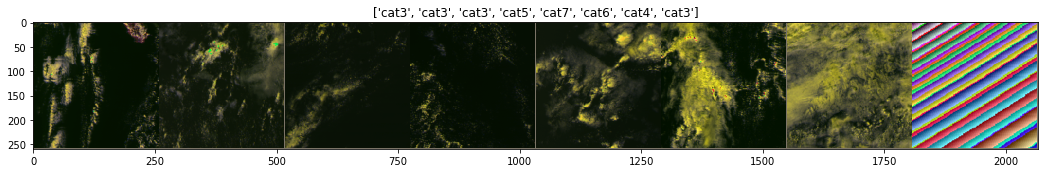

In [210]:
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

print(out.shape)
imshow(out, title=[class_names[x] for x in classes])

In [167]:
f = r"/home/disk/eos4/jkcm/Data/MEASURES/classified_data/120data/npz/train/cat1/IMG_MYD02HKM.A2012012.2240.061_index_1792_index_1536_Block128x128.npz"

In [15]:
f = r"/home/disk/eos4/jkcm/Data/MEASURES/classified_data/npz/train/cat1/MOD_MYD02HKM.A2012204.2100.061_index_0768_index_1280_Block128x128.npz"

In [16]:
x = np.load(f)

In [20]:
x.files

['Lon', 'Lat', 'CER', 'CER_PCL', 'CER_Fail', 'COT', 'COT_PCL', 'COT_Fail']

In [48]:
from PIL import Image
path = f
l = np.load(path)
r = l['Ref_Band2']*256
g = l['Ref_Band4']*256
b = l['Ref_Band7']*256
arr = np.stack([r,g,b], axis=2).astype('uint8')
im = Image.fromarray(arr)
im.show()

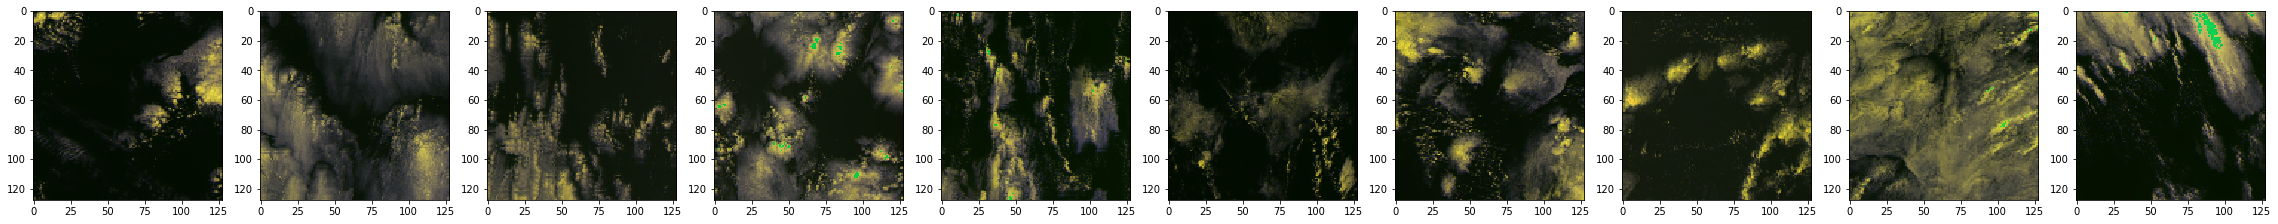

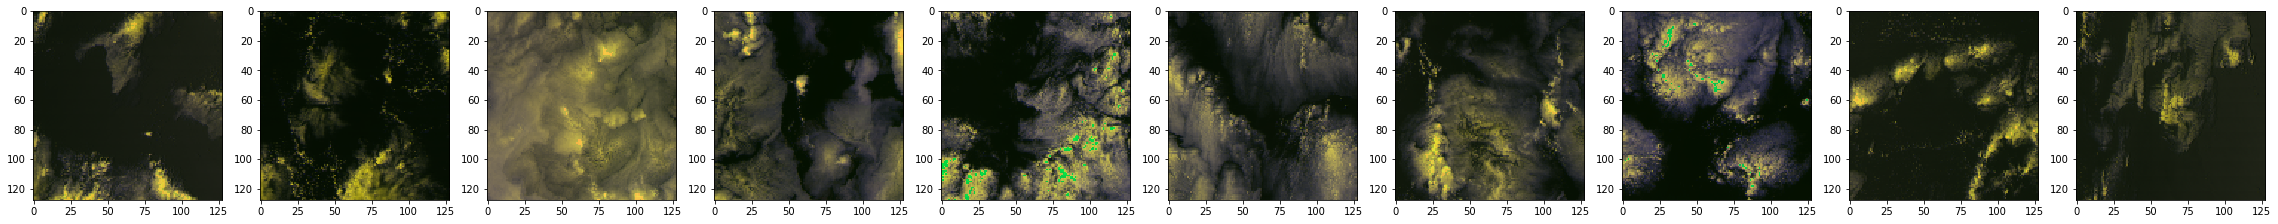

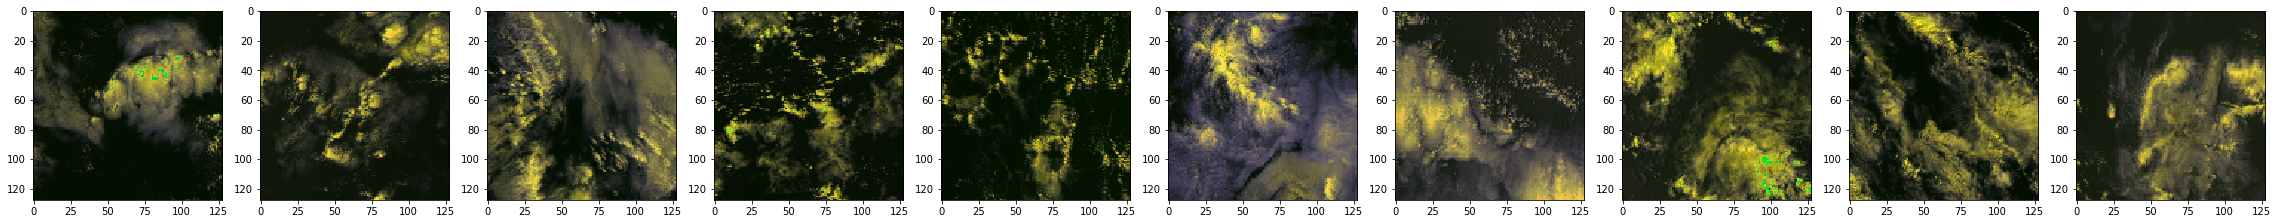

In [213]:
from random import choice

def show_img(path, ax=None):
    l = np.load(path)
    r = l['Ref_Band2']*256
    g = l['Ref_Band4']*256
    b = l['Ref_Band7']*256
    arr = np.stack([r,g,b], axis=2).astype('uint8')
    im = Image.fromarray(arr)
#     im.show()
    if ax:
        ax.imshow(np.asarray(im))
    else:
        plt.imshow(np.asarray(im))

    
basedir = r"/home/disk/eos4/jkcm/Data/MEASURES/classified_data/npz/train/cat3"
list_of_cat3s = [os.path.join(basedir, i) for i in os.listdir(basedir) if valid_file(i)]

def show_randn(imlist, n=1):
    fig, ax = plt.subplots(ncols=n, figsize=(40,20))
    for axi in ax:
        f = choice(imlist)
        show_img(f,axi)
        
show_randn(list_of_cat3s, 10)
show_randn(list_of_cat3s, 10)
show_randn(list_of_cat3s, 10)